In [ ]:
!pip install --upgrade diffusers transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 712.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 23.4 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
import tqdm
import torch
import pandas as pd
import numpy as np
from diffusers import StableDiffusionPipeline
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cv2
from PIL import Image

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
class CFG:
    device = "cuda"
    seed = 42
    generator = torch.Generator(device).manual_seed(seed)
    image_gen_steps = 35
    image_gen_model_id = "stabilityai/stable-diffusion-2"
    image_gen_size = (400,400)
    image_gen_guidance_scale = 9
    prompt_gen_model_id = "gpt2"
    prompt_dataset_size = 6
    prompt_max_length = 12

In [ ]:
image_gen_model = StableDiffusionPipeline.from_pretrained(
    CFG.image_gen_model_id,
    torch_dtype=torch.float16,
    revision="fp16",
    guidance_scale=CFG.image_gen_guidance_scale
)

image_gen_model = image_gen_model.to(CFG.device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/511 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:221: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/815 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/900 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

Keyword arguments {'guidance_scale': 9} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
from PIL import Image

In [ ]:
def generate_character_sheet(image_url, prompt, model):
    # Step 1: Download the image from Google Drive
    gdd.download_file_from_google_drive(file_id=image_url, dest_path='input_image.png')

    # Step 2: Load the image
    input_image = Image.open('input_image.png')

    # Step 3: Process the prompt and modify the image as needed
    modified_image = process_image_with_prompt(input_image, prompt)

    # Step 4: Generate front, back, and items images
    front_image = generate_image_view(modified_image, "Front view of " + prompt, model)
    back_image = generate_image_view(modified_image, "Back view of " + prompt, model)
    items_image = generate_image_view(modified_image, "Items carried by " + prompt, model)

    # Step 5: Create and return the character sheet
    character_sheet = create_character_sheet(front_image, back_image, items_image)

    return character_sheet

def process_image_with_prompt(image, prompt):
    # Implement logic to modify the image based on the prompt
    # For example, changing gender or clothing style
    return modified_image

def generate_image_view(base_image, view_prompt, model):
    # Generate an image view based on the base image and prompt
    return model(
        view_prompt, num_inference_steps=CFG.image_gen_steps,
        generator=CFG.generator,
        guidance_scale=CFG.image_gen_guidance_scale
    ).images[0]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['show liora casting a healing spell with a gentle smile . 7 . back view : display her staff glowing and her robe flowing . 8 . side view : highlight her calm demeanor and delicate features 9 . items : healing potions , spellbook . 1 0 . background : a serene temple with soft light .']


  0%|          | 0/35 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['show liora casting a healing spell with a gentle smile . 7 . back view : display her staff glowing and her robe flowing . 8 . side view : highlight her calm demeanor and delicate features 9 . items : healing potions , spellbook . 1 0 . background : a serene temple with soft light .']


  0%|          | 0/35 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['show liora casting a healing spell with a gentle smile . 7 . back view : display her staff glowing and her robe flowing . 8 . side view : highlight her calm demeanor and delicate features 9 . items : healing potions , spellbook . 1 0 . background : a serene temple with soft light .']


  0%|          | 0/35 [00:00<?, ?it/s]

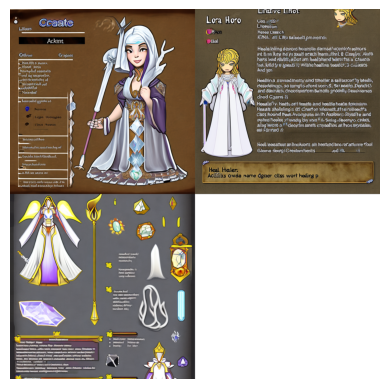

In [ ]:
prompt_description = "Create a game character sheet for a character named Liora. Include the following sections:  1. Name: Liora 2. Class: Healer 3. Description: A kind-hearted mage with flowing white robes and a staff adorned with crystals. 4. Abilities: Heal, Revive, Barrier 5. Accessories: Crystal Staff, Healing Potion 6. Front view: Show Liora casting a healing spell with a gentle smile. 7. Back view: Display her staff glowing and her robe flowing.  8. Side view: Highlight her calm demeanor and delicate features 9. Items: Healing potions, spellbook. 10. Background: A serene temple with soft light."
character_sheet_image = generate_image(prompt_description, image_gen_model)

# Display the generated character sheet
plt.imshow(character_sheet_image)
plt.axis('off')
plt.show()

  0%|          | 0/35 [00:00<?, ?it/s]

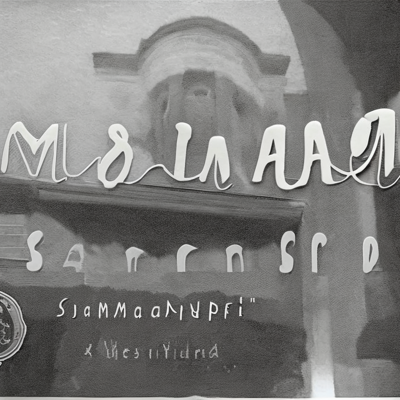

In [ ]:
generate_image("Samarpita",image_gen_model)